# Sprint 2

This notebook was created by Lennart Onghena, Roel Moeyersoons and Tim De Smet.

This project is a collaboration with ML6. They are launching a product that automates parts of big email inboxes.

During `sprint 1` we created a classifier that for the message of the customers based on the product.

During `sprint 2` we attempt to do the same using clustering by unsupervised learning instead of supervised classification.

In [38]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import re
import string
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples

from sklearn.cluster import DBSCAN

# TODOS

SAMEN:

* Waarom doen we wat & tekst nalezen
* Wie heeft er aan wat gewerkt invullen

TIM: 
* <span style="color:green" >tf-idf checken : DE FOUT ZAT BIJ DE PARAMETERS VAN DE TFIDFVECTORIZER</span>
* Kmeans:
    * <span style="color:green">Simpl & balancing initieel achterwege laten</span>
    * <span style="color:green">kleuren bij k-means checken</span>
    * <span style="color:green">Keras naar sprint 3</span>
    *  <span style="color:green" >Plot bij train/test/split verplaatsen want is based on simpl & balancing: DONE</span>

LENNART:
* silhouette coeff plotten rond elbow (rond 6) (uitleggen dat aantal categorieën vrij goed gekozen is)
* Naar meerdere dim gaan
* Doc2Vec sklearn api
* HDBscan implementeren
* Evaluatie HDBScan

ROEL:
* Naar meerdere dim gaan
* DBScan verschillende metrics onderzoeken
* DBscan + uitleggen waarom niet goed werkt met verschillende sizes clusters (onze data is niet evenwichtig)
* Evaluatie DBScan

# 1. EDA

All EDA steps were performed during `sprint 1`.

# 2. Preprocessing


In order to address the problems of the data, we prepared our data.


## 2.1. Read

In [3]:
complaints = pd.read_csv('complaints-2020-01-22_08_24.csv')

Having the data allows us to create some constants:

In [47]:
# Basic constants
SAMPLE_AMOUNT = 10000
VISUAL_AMOUNT = SAMPLE_AMOUNT
PRODUCT_AMOUNT = len(set(complaints['Product']))

## 2.2. Sampling

Let's now take a sample from this set that shall be used during the project. The size of the subsample is very important. Too little and your model might be overtuned to some texts, while being undertuned to others. 

The bigger the subsample the more accurate your model will be for the whole dataset. However, in order to not overburden our CPU's, we limit it during the project to 10000. 

A fixed seed is also added so that the same sample is produced every time. We do this in order to keep consistency when running hte notebook several times over and over but it's not stictly needed. Needless to say this can lead to exploits where the model performs very well for this one sample. This is not our intention, the only reason the seed given below is used is because it gives an equalish amount of rows for every target. 

In [40]:
data = complaints.sample(SAMPLE_AMOUNT, random_state=7844569)

## 2.3. Text cleaning

We learned from `sprint 1` that cleaning the text is very important. We only applied this in the final phases of `sprint 1`. However, we decided to learn from our mistakes and do this right away during this sprint.
We can clearly see the text contains special characters, numbers, anonymized data, html, etc...
This needed to be dealt with.

In [7]:
pd.set_option('max_colwidth', None)
data[['Product','Consumer complaint narrative']].head()

,Product,Consumer complaint narrative
234227,"Credit reporting, credit repair services, or other personal consumer reports","XXXX XXXX XXXX XXXX XXXX XXXX XXXX CA XXXX SSN : XXXX Experian XXXX. XXXX XXXX XXXX, TX XXXX According to the Fair Credit Reporting Act, you are required by federal law to verify-through the physical verification of the original signed consumer contract -any and all accounts you post on a credit report. Otherwise, anyone paying for your reporting services could fax, mail or email in a fraudulent account. \nI demand to see the Verifiable Proof ( an original Consumer Contract with my Signature on it ) you have on file of the accounts listed below. Your failure to positively verify these accounts has hurt my ability to obtain credit. Under the FCRA, unverified accounts must be removed and if you are unable to provide me a copy of verifiable proof, you must remove the accounts listed below. \nI demand the following accounts be verified or removed immediately Name of Account XXXX XXXX XXXX Provide Physical Verification Creditor 1 XXXX C/O XXXX XXXX XXXX UNKOWN XXXX XXXX XXXX XXXX, SC XXXX"
482889,"Credit reporting, credit repair services, or other personal consumer reports","I recently received a letter from Equifax dated XX/XX/2018 stating that 'We have received your request concerning a security freeze on your Equifax credit report. Unfortunately, we were unable to process your request because we need additional information. ' Then the letter requests that I submit items to validate my identity and address. \nI have made no recent requests to Equifax concerning my security freeze. \nMy security freeze should be current and in place. \n\nI do not know why Equifax sent me this letter claiming that I made a request concerning a security freeze when I did not."
23996,Mortgage,"I have been with Lakeview Loan Servicing/XXXX XXXX XXXX XXXX ( hereafter referred to as "" XXXX '' ). Mortgage for three years. I recently made the decision to refinance and thus change mortgage companies and homeowner 's insurance companies. XXXX is responsible for paying my homeowner 's insurance from my escrow account and has done so without issue in the past. Recently, they allowed my insurance policy to lapse for non-payment. The company was notified of the pending cancellation via letter from XXXX XXXX. Prior to this happening, I had called to notify them of the change of insurance companies and provided them with the necessary information to continue making payments. It was only once I received notification from the new insurance company ( XXXX XXXX ) and the refinance company ( XXXX XXXX ) that I was made aware that the policy had not been paid. Not only was this holding up my refinance but the policy was due for cancellation. I immediately contacted the insurance company and was told that the payment needed to be sent overnight. I contacted XXXX and was assured that the payment would be sent via overnight. Days later, I was notified by XXXX XXXX that the policy had still not been paid. I called XXXX again and was told that the payment had in fact not been sent because the representative I had spoken to did not provide "" adequate documentation '' when making the requests for payment. Instead of XXXX notifying me that they payment was not paid, they simply ignored it and allowed my policy to lapse ( unbeknownst to me ). \nWhile this may appear to be simply a careless mistake, I am convinced that since I had made a decision to go with a different mortgage company, XXXX maliciously and intentionally neglected to pay my homeowner 's insurance. I am requesting that this incident be investigated."
55010,Debt collection,I rented a apartment at XXXX XXXX XXXX XXXX It was unit # XXXX. Upon repeated harassment from tenants below us I decided to move after the women who lived there tried to force their way into my unit. I called management repeatedly and was told it is a personal matter. After I felt unsafe I left on XXXX fearing for mine a

We created a function filtering out the following unwanted things:
- html
- anonymized data
- numbers
- uppercase
- stopwords

We first tried lemmatization but this did not change much that's why we decided to use a harsher stemming approach.

In [41]:
stopWords = stopWords = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
  
def preprocessing(text):
    text = BeautifulSoup(text, "html.parser").text
    translator = str.maketrans('', '', string.punctuation) 
    text = text.translate(translator).lower()
    text = re.sub(r'(x)\1+', '', text)
    text = re.sub(r'[0-9]', r' ', text)
    tokens = []
    for word in text.split():
        word = stemmer.stem(word)
        if word not in stopWords:
            tokens.append(word)
    return " ".join(tokens)

In [42]:
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(preprocessing)
data[['Product','Consumer complaint narrative']].head()

,Product,Consumer complaint narrative
234227,"Credit reporting, credit repair services, or other personal consumer reports",ca ssn experian tx accord fair credit report act requir feder law verifythrough physic verif origin sign consum contract ani account post credit report otherwis anyon pay report servic could fax mail email fraudul account demand see verifi proof origin consum contract signatur file account list failur posit verifi account hurt abil obtain credit fcra unverifi account must remov unabl provid copi verifi proof must remov account list demand follow account verifi remov immedi name account provid physic verif creditor co unkown sc
482889,"Credit reporting, credit repair services, or other personal consumer reports",recent receiv letter equifax date state receiv request concern secur freez equifax credit report unfortun unabl process request becaus need addit inform letter request submit item valid ident address made recent request equifax concern secur freez secur freez current place know whi equifax sent letter claim made request concern secur freez
23996,Mortgage,lakeview loan servic hereaft refer mortgag three year recent made decis refin thus chang mortgag compani homeown insur compani respons pay homeown insur escrow account done without issu past recent allow insur polici laps nonpay compani notifi pend cancel via letter prior happen call notifi chang insur compani provid necessari inform continu make payment onli onc receiv notif new insur compani refin compani made awar polici paid onli hold refin polici due cancel immedi contact insur compani told payment need sent overnight contact assur payment would sent via overnight day later notifi polici still paid call told payment fact sent becaus repres spoken provid adequ document make request payment instead notifi payment paid simpli ignor allow polici laps unbeknownst may appear simpli careless mistak convinc sinc made decis go differ mortgag compani malici intent neglect pay homeown insur request incid investig
55010,Debt collection,rent apart unit upon repeat harass tenant us decid move women live tri forc way unit call manag repeat told person matter felt unsaf left fear mine daughter safeti debt turn collect agenc rent paid leas collect agenc contact demand take care debt point major issu rent paid owe non payment transact bank statement leas yet say owe day rent paid carpet damag walk report bad damag fray move mos never receiv ani inform item bill anyon yet tri collect debt build non smoke build constant smoke blown unit stair balconi door vent bathroom leas say prohibit activ threaten behavior disturb safeti im women tri forc way unit call manag offic sever time tell repeat bulli harass told person matter
212855,"Credit reporting, credit repair services, or other personal consumer reports",credit repor ting agenc report inaccuraci credit report disput inform ask inform nt provid address never resid credit report suggest along unknown address numer account credit report open ask credit bureaus look disput inform correct inaccuraci noth done inform hurt credit score nd credit report hold back thing need


After applying the function to the whole column, we can see the results are as expected.

## 2.4. Feature Extraction

In order for the computer to understand the customers complaints we needed to use Natural Language Processing techniques. We need to extract features from the messages.

### TF-IDF

We chose TF-IDF for its normalization features instead of using a simple bag of words. We remembered: "A word that occurs often in a certain document but does not occur often in other documents is probably an important word for this document." This seemed very useful in our case since mails generally follow a fixed pattern and use rather similar vocabulary.

In [43]:
def tfidf():
    tfidf = TfidfVectorizer()
    transformed = tfidf.fit_transform(data['Consumer complaint narrative'])
    print(f'Resulting shape: {transformed.shape}')
    return transformed

### Doc2Vec

We tested Doc2Vec aswell and considered every mail as a document. We hoped this would locate corresponding emails close to eachother. 

In [44]:
def doc2vec():
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(row.split() for row in data['Consumer complaint narrative'])]
    model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4)
    model.build_vocab(documents)
    model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
    
    transformed = []
    for doc in documents:
        transformed.append(model.infer_vector(doc.words, epochs=model.epochs))
    
    transformed = np.asarray(transformed)
    print(f'Resulting shape: {transformed.shape}')
    return transformed

In [45]:
# Chosen FE technique:
transformed = tfidf()

Resulting shape: (10000, 13567)


## 2.5. Dimensionality Reduction

### Truncated SVD

Since TF-IDF works with a sparse matrix we used TSVD to reduce the dimensions. 

In [13]:
def tsvd(n):
    svd = TruncatedSVD(n_components=n)
    reduced = svd.fit_transform(transformed)
    print(f'Resulting shape: {reduced.shape}')
    return reduced

### PCA

We noticed that TSVD in combination with Doc2Vec was not optimal for this use case, all points were located very close to eachother. Instead we tried PCA and found minor improvement.

In [14]:
def pca(n):
    pca = PCA(n_components=n)
    reduced = pca.fit_transform(transformed)
    print(f'Resulting shape: {reduced.shape}')
    return reduced

### TSNE

Because we weren't satisfied with the results PCA and TSVD and our goal is visualization we decided to try TSNE. Language data is high in dimensions. TSNE is a better projection of multidimensional space onto two dimensional space than PCA. 

In [15]:
def tsne(n):
    tsne = TSNE(n_components=n)
    reduced = tsne.fit_transform(transformed)
    print(f'Resulting shape: {reduced.shape}')
    return reduced

In [46]:
# chosen DR technique:
reduced = tsne(2)

Resulting shape: (10000, 2)


# 2.8. Train/Validate/Test Split

Since we want to be able to validate the data we need a train/validate/test split.

In [48]:
y = data['Product']
x = reduced

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.1)

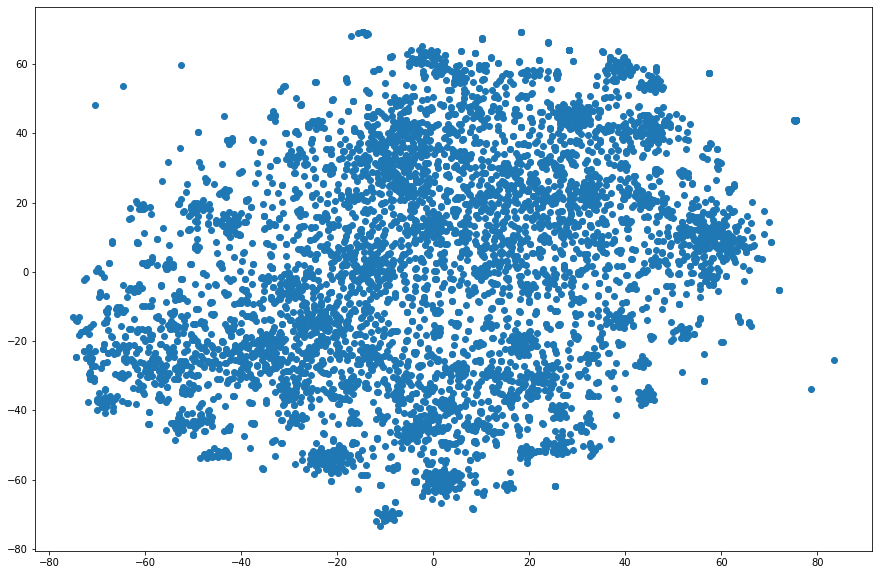

In [49]:
plt.figure(figsize=(15,10))
plt.scatter(x_train[:VISUAL_AMOUNT,0], x_train[:VISUAL_AMOUNT,1])

# 3. Kmeans Clustering

Since we have a rough idea of how many clusters we would expect (because we already simplified the data) we decided first to try Kmeans clustering with the same number of clusters as we created our own categories.

In [50]:
# ordered list of all products
products = list(set(complaints['Product']))
products.sort()

In [51]:
kmeans = KMeans(n_clusters=PRODUCT_AMOUNT)
predictions = kmeans.fit_predict(x_train)

## 3.1. Initial Analysis

In order to see how good the model works out of the box we want to know how accurate it managed to create these clusters according to our ground truth.

In [52]:
def calculateStatistics(ground_labels, predicted):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
   
    #check all pairs 
    for i in range(len(ground_labels)):
        for j in range(i+1, len(ground_labels)):
            # if they belong to the same cluster in round truth
            if ground_labels[i] == ground_labels[j]:
                # did they also match the same cluster from kmeans?
                if predicted[i] == predicted[j]:
                    TP = TP + 1
                else:
                    FN = FN + 1
            else:
                if predicted[i] == predicted[j]:
                    FP = FP + 1
                else:
                    TN = TN + 1
    return TP, FP, TN, FN

def printStatistics(TP, FP, TN, FN):
    print("TP : " + str(TP))
    print("TN : " + str(TN))
    print("FP : " + str(FP))
    print("FN : " + str(FN))
    print("right: " + str(TP + TN))
    print("wrong: " + str(FN + FP))
    print("ratio: " + str((TP + TN)/(FN + FP + TP + TN)))
    print("precision over all clusters: " + str(TP/(TP + FP)))
    print("recall over all clusters: " + str(TP/(TP + FN)))

In [53]:
ground_labels = [products.index(p) for p in y_train]

In [54]:
TP, FP, TN, FN = calculateStatistics(ground_labels, kmeans.labels_)
printStatistics(TP, FP, TN, FN)

TP : 443852
TN : 15805518
FP : 697311
FN : 2895169
right: 16249370
wrong: 3592480
ratio: 0.8189443020686075
precision over all clusters: 0.3889470654060813
recall over all clusters: 0.13292878361651514


# ROEL

The right/wrong ratio would indicate that it seems to perform very well, however this is simply not true. It is dominated by the amount of TN of which there naturally are a lot. 

Changing nothing we get an accuracy of about 30%. Considering the fact a random classifier with 6 classes has 16,6% accuracy (the perfect one 100%) we are at least doing better than random. But we don't consider 30% as sufficient so we asked ourselves why this could be? The main reasons we decided to explore further were:

- our arbitrary number of categories was wrong, the machine could possibly be right
- a general lack of hyperparameter tuning

When we look at a sample we don't even see indications of clusters:

In [55]:
# Create the amount of random colors required
def create_colors(n):
    colormap = []
    for i in range(n):
        colormap.append(np.random.rand(3,))
    return colormap

In [56]:
colormap=create_colors(PRODUCT_AMOUNT)
product_indices = list(map(lambda x : products.index(x), y_train[:VISUAL_AMOUNT]))

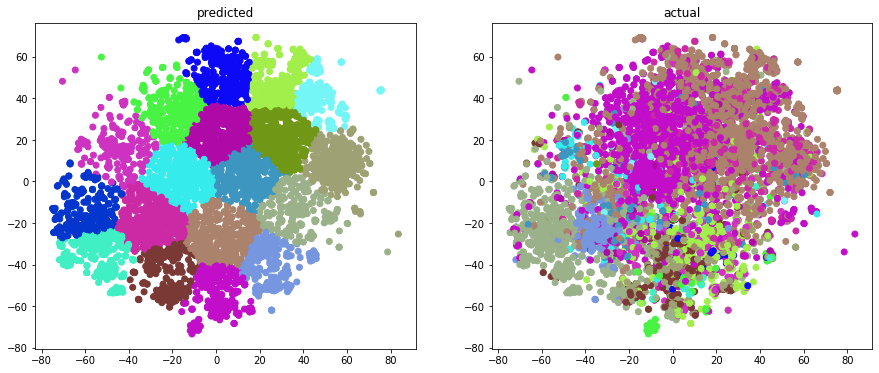

In [57]:
def compare_visually(x_train, predictions, product_indices, colormap):
    fig = plt.figure(figsize=(15,6))

    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title('predicted')
    ax1.scatter(x_train[:VISUAL_AMOUNT,0], x_train[:VISUAL_AMOUNT,1], c=[colormap[i] for i in predictions[:VISUAL_AMOUNT]])

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('actual')
    ax2.scatter(x_train[:VISUAL_AMOUNT,0], x_train[:VISUAL_AMOUNT,1], c =[colormap[i] for i in product_indices])
    
compare_visually(x_train, predictions, product_indices, colormap)

We can see that k-means find clusters. However we see that the data itself is not clustered according to products nicely when we set the amount of clusters to 18 (= the amount of products given). We decided to see if a different value of clusters made more sense.

## 3.2. Determing K

We determined K using the elbow method and silhouette analysis.

In [58]:
def silhouette(k):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, tol=1e-04,random_state=0)
    y_km = km.fit_predict(x_train)

    import numpy as np
    from matplotlib import cm
    from sklearn.metrics import silhouette_samples

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(x_train, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
      c_silhouette_vals = silhouette_vals[y_km == c]
      c_silhouette_vals.sort()
      y_ax_upper += len(c_silhouette_vals)
      color = cm.jet(float(i) / n_clusters)
      plt.barh(range(y_ax_lower, y_ax_upper),
               c_silhouette_vals,
               height=1.0,
               edgecolor='none',
               color=color)
      yticks.append((y_ax_lower + y_ax_upper) / 2.)
      y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

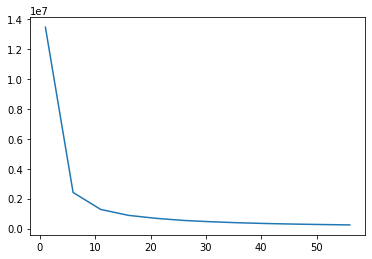

In [61]:
def elbow(start, end, step):
    oplossingen = []
    for i in range(start,end,step):
        kmeans = KMeans(n_clusters=i, init='k-means++')
        kmeans.fit(x_train)
        oplossingen.append(kmeans.inertia_)
    plt.plot(range(start,end,step),oplossingen)
    
elbow(1,60,5)

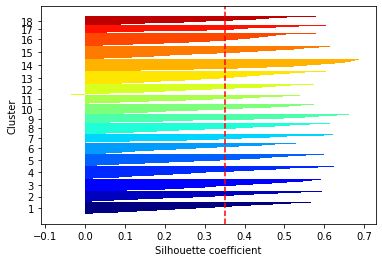

In [59]:
silhouette(PRODUCT_AMOUNT)

Silouhette analysis shows us that it actually does a fairly descent job. 

This elbow analysis indicates that a smaller K value would be more interesting. In `sprint 1` during the EDA phase we actually noticed that the product column was very overlapping at times. That is why we simplified the 18 categories to 6 categories. The elbow analysis seems to suggest that this was the right move. We take a more detailed look:

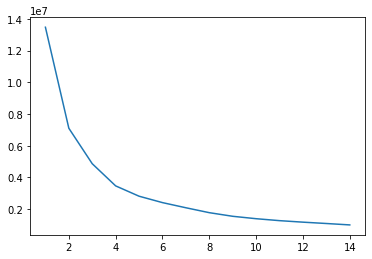

In [62]:
elbow(1,15,1)

The second elbow seems to confirm what we found during `sprint 1`. We check with an other silhouette analysis if this would be valid:

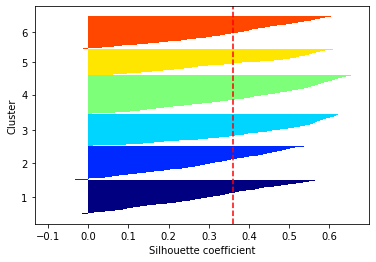

In [64]:
silhouette(6)

## 3.3. TFIDF + TSNE + Kmeans: 6 clusters

Since we found 6 clusters to be more appropriate according to elbow analysis we decided to implement this model.
We train the model with 6 clusters in order to check for improvement:

In [80]:
kmeans = KMeans(n_clusters=6)
predictions = kmeans.fit_predict(data)

ValueError: could not convert string to float: 'Yes'

In [79]:
labeled = x_train.copy()
#labeled['LABEL'] = predictions
#targets = np.unique(labeled['TARGET'])
#labels = np.unique(labeled['LABEL'])
#fractions = {}
#for target in targets:
#    total = np.count_nonzero(labeled['TARGET'] == target)
#    fractions[target] = [None] * len(labels)
#    for label in labels:
#        is_target = labeled['TARGET'] == target
#        is_label = labeled['LABEL'] == label
#        match = labeled[is_target & is_label]
#        fractions[target][label] = match.shape[0]/total
#
#index = []
#values = []
#for key in fractions:
#    index.append(key)
#    values.append(fractions[key])
#    print(key)
#    for value in fractions[key]:
#        print("\t" + str(value))

# ROEL

In [157]:
TP, FP, TN, FN = calculateStatistics(ground_labels, kmeans.labels_)
printStatistics(TP, FP, TN, FN)

TP : 1154880
TN : 14294317
FP : 2218162
FN : 2174491
right: 15449197
wrong: 4392653
ratio: 0.7786167620458778
precision over all clusters: 0.3423853008649166
recall over all clusters: 0.3468763318957244


We decided to examine how our assumption from `sprint 1` performed according to this clustering:

In [66]:
simp_map = {
    'Debt collection' : 'F', 
    'Payday loan' : 'B', 
    'Mortgage' : 'A', 
    'Bank account or service' : 'E', 
    'Consumer Loan' : 'B', 
    'Other financial service' : 'E', 
    'Vehicle loan or lease' : 'B',
    'Payday loan, title loan, or personal loan' : 'B', 
    'Money transfers' : 'E', 
    'Student loan' : 'B', 
    'Virtual currency': 'E', 
    'Credit reporting, credit repair services, or other personal consumer reports' : 'D', 
    'Credit card' : 'C', 
    'Checking or savings account' : 'E', 
    'Prepaid card' : 'C', 
    'Money transfer, virtual currency, or money service' : 'E', 
    'Credit reporting': 'D', 
    'Credit card or prepaid card' : 'C'}

featureSet = complaints[['Product', 'Consumer complaint narrative']].copy()
featureSet['TARGET'] = featureSet['Product'].map(simp_map)

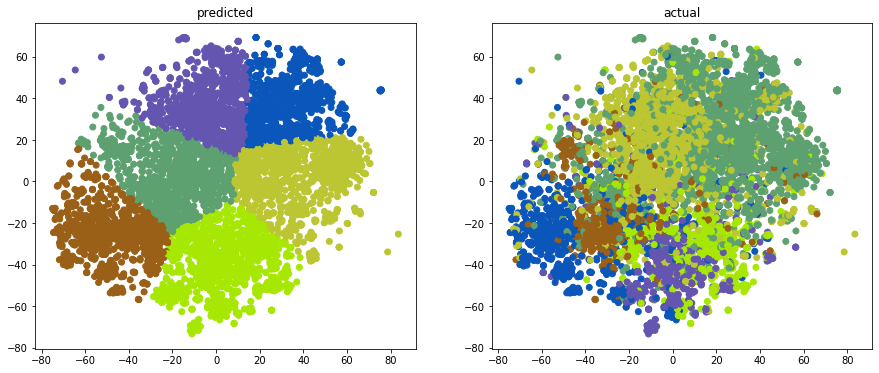

In [67]:
colormap = create_colors(6)
product_indices = list(map(lambda x : ord(simp_map[x])-ord('A'), y_train[:VISUAL_AMOUNT]))

compare_visually(x_train, predictions, product_indices, colormap)

By looking at chart that describes our simplification we still don't have clear patterns.
This lead us to believe that the clusters created with TF-IDF + TSNE + KMeans were non-sensical. 

## 3.4. Doc2Vec + TSNE + KMeans (6 clusters)

Since we can see in both cases (products or simplified products) points are very scattered we decided to try a different feature extraction technique.

In [68]:
transformed = doc2vec()

Resulting shape: (10000, 20)


In [69]:
reduced = tsne(2)

Resulting shape: (10000, 2)


In [70]:
kmeans = KMeans(n_clusters=6)
predictions = kmeans.fit_predict(x_train)

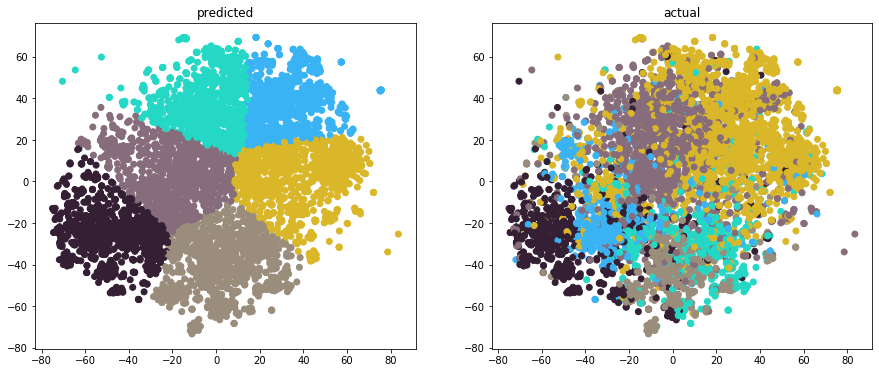

In [71]:
colormap=create_colors(6)
product_indices = list(map(lambda x : ord(simp_map[x])-ord('A'), y_train[:VISUAL_AMOUNT]))
compare_visually(x_train, predictions, product_indices, colormap)

The same problemen keeps presenting itself. Furthermore we noticed that the actual product groupings were not spherical (and Kmeans assumes this) we decided to try DBScan clustering instead because kmeans might not be fitting for the data.

## 4. DBScan Clustering

Looking at the images where ground truths are shown we see that the clusters are not circular, however kmeans expects this. That is why we decided to try DBScan aswell. This technique works with densities instead of distances, which allows it to model non-circular clusters.

In [51]:
db = DBSCAN(eps=1.5, min_samples=4)
y_db = db.fit_predict(x_train)

## 4.1. Initial Analysis

In order to see how good the model works out of the box we want to know how accurate it managed to create these clusters according to our ground truth.

In [39]:
ground_labels = [ord(text[-1])-ord('A') for text in y_train]
TP, FP, TN, FN = calculateStatistics(ground_labels, db.labels_)
printStatistics(TP, FP, TN, FN)

TP : 343326
TN : 15533916
FP : 998127
FN : 2966481
right: 15877242
wrong: 3964608
ratio: 0.8001895992561178
precision over all clusters: 0.255935914266098
recall over all clusters: 0.10372991536968772


A basic implementation groups everything together in one cluster. Here we need some hyperparameter tuning.

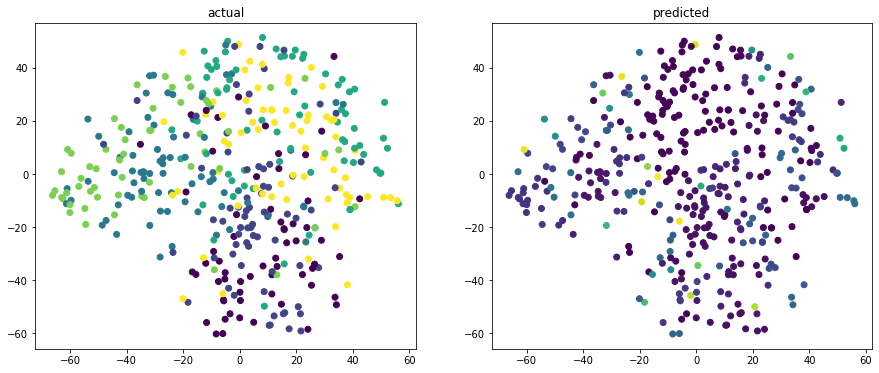

In [52]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(1,2,2)
ax1.set_title('predicted')
ax1.scatter(x_train[:400,0], x_train[:400,1], c=y_db[:400])

ax2 = fig.add_subplot(1,2,1)
ax2.set_title('actual')
ax2.scatter(x_train[:400,0], x_train[:400,1], c=[ord(a) for a in y_train[:400]])

# 5. HDBscan 

